In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras import applications
from datetime import datetime as dt
from keras import regularizers as reg
from keras.optimizers import RMSprop
from keras.utils import to_categorical
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [3]:
global_start=dt.now()

#Dimensions of our flicker images is 256 X 256
img_width, img_height = 256, 256

#Declaration of parameters needed for training and validation
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
epochs = 40
batch_size = 16

#Get the bottleneck features by  Weights.T * Xi
def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1./255)

    #Load the pre trained VGG16 model from Keras, we will initialize only the convolution layers and ignore the top layers.
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator_tr = datagen.flow_from_directory(train_data_dir,
                                            target_size=(img_width, img_height),
                                            batch_size=batch_size,
                                            class_mode=None, #class_mode=None means the generator won't load the class labels.
                                            shuffle=False) #We won't shuffle the data, because we want the class labels to stay in order.
    nb_train_samples = len(generator_tr.filenames) #3600. 1200 training samples for each class
    bottleneck_features_train = model.predict_generator(generator_tr, nb_train_samples // batch_size)
    np.save('weights/bottleneck_features_train.npy',bottleneck_features_train) #bottleneck_features_train is a numpy array

    generator_ts = datagen.flow_from_directory(validation_data_dir,
                                            target_size=(img_width, img_height),
                                            batch_size=batch_size,
                                            class_mode=None,
                                            shuffle=False)
    nb_validation_samples = len(generator_ts.filenames) #1200. 400 training samples for each class
    bottleneck_features_validation = model.predict_generator(generator_ts, nb_validation_samples // batch_size)
    np.save('weights/bottleneck_features_validation.npy',bottleneck_features_validation)
    print("Got the bottleneck features in time: ",dt.now()-global_start)
    
    num_classes = len(generator_tr.class_indices)
    
    return nb_train_samples,nb_validation_samples,num_classes,generator_tr,generator_ts
    
nb_train_samples,nb_validation_samples,num_classes,generator_tr,generator_ts=save_bottlebeck_features()

Found 3600 images belonging to 3 classes.
Found 1200 images belonging to 3 classes.
Got the bottleneck features in time:  1:21:46.450842


In [12]:
#After we get the bottleneck features, we will build the top fully connected layers on top of the bottlneck features. Let's build the top layers.
def train_top_model():
    global_start=dt.now()

    train_data = np.load('weights/bottleneck_features_train.npy')
    validation_data = np.load('weights/bottleneck_features_validation.npy')
    
    #train_labels = np.array([0] * (nb_train_samples // 3) + [1] * (nb_train_samples // 3) + [2] * (nb_train_samples // 3)) #Equivalent to: np.array([0]*1200 + [1]*1200 + [2]*1200)
    #validation_labels = np.array([0] * (nb_validation_samples // 3) + [1] * (nb_validation_samples // 3) + [2] * (nb_validation_samples // 3))
    train_labels=generator_tr.classes  
    validation_labels=generator_ts.classes
    
    train_labels = to_categorical(train_labels, num_classes=num_classes)  
    validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:])) #Ignore the first index. It contains ID

    model.add(Dense(256, activation='relu',kernel_initializer='he_normal',kernel_regularizer=reg.l1_l2(l1=0.001, l2=0.001))) #Best weight initializer for relu is he_normal
    model.add(BatchNormalization()) #Add a BatchNormalization layer to control internel covariance shift
    model.add(Dropout(rate=0.5)) #Using droput for regularization

    model.add(Dense(256, activation='relu',kernel_initializer='he_normal',kernel_regularizer=reg.l1_l2(l1=0.001, l2=0.001)))
    model.add(BatchNormalization()) #Add a BatchNormalization layer to control internel covariance shift
    model.add(Dropout(rate=0.5))

    model.add(Dense(num_classes, activation='softmax',kernel_initializer='glorot_uniform')) #Because we have 3 classes. Remember, softmax is to multi-class, what sigmoid (log reg) is to binary

    optim=RMSprop(lr=0.0001, epsilon=1e-8, decay=1e-6)
    model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['accuracy'])
    model.summary()

    model.fit(x=train_data,
              y=train_labels,
              epochs=epochs,
              validation_data=(validation_data, validation_labels))    
    model.save_weights('weights/bottleneck_feats_multi_weights.h5') 
    model.save('weights/bottleneck_feats_multi_model.h5')
    print("The top layer trained in time: ",dt.now()-global_start)
    
    return model

model=train_top_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               8388864   
_________________________________________________________________
batch_normalization_13 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_14 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
__________

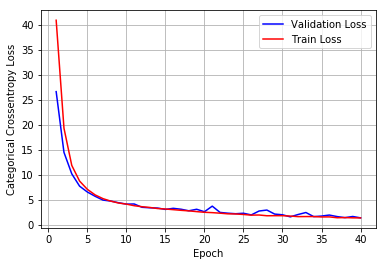

In [15]:
#This function is used to plot/update the train and test loss after each epoch.
import matplotlib.pyplot as plt
def plt_dynamic_loss(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

#Get model history
history=model.history

'''#Plot the train and test loss vs number of epochs
score = model.evaluate(X_test, y_test, verbose=0) 
print('Test score (Validation Loss):', score[0]) 
print('Test accuracy (Accuracy on Unseen Data):', score[1])'''

#Plot train vs test loss
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

#List of epoch numbers
x = list(range(1,epochs+1))

#Display the loss
val_loss = history.history['val_loss'] #Validation Loss
loss = history.history['loss'] #Training Loss
plt_dynamic_loss(x, val_loss, loss, ax)

In [17]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model
import time


#Define image parameters. This should be same as the dimensions of the input image
img_width, img_height = 256, 256

#Make predictions using this function. Call this function with the file name
def predict_image(file):
    start = time.time()
    test_image = load_img(file, target_size=(img_width,img_height))
    test_image = img_to_array(test_image)
    test_image = test_image / 255.0
    test_image = np.expand_dims(test_image, axis=0)


    model = applications.VGG16(include_top=False, weights='imagenet')
    bottleneck_prediction = model.predict(test_image)  

    model = Sequential()
    model.add(Flatten(input_shape=bottleneck_prediction.shape[1:])) #Ignore the first index. It contains ID

    model.add(Dense(256, activation='relu',kernel_initializer='he_normal',kernel_regularizer=reg.l1_l2(l1=0.001, l2=0.001))) #Best weight initializer for relu is he_normal
    model.add(BatchNormalization()) #Add a BatchNormalization layer to control internel covariance shift
    model.add(Dropout(rate=0.5)) #Using droput for regularization

    model.add(Dense(256, activation='relu',kernel_initializer='he_normal',kernel_regularizer=reg.l1_l2(l1=0.001, l2=0.001)))
    model.add(BatchNormalization()) #Add a BatchNormalization layer to control internel covariance shift
    model.add(Dropout(rate=0.5))

    model.add(Dense(3, activation='softmax',kernel_initializer='glorot_uniform')) #Because we have 3 classes. Remember, softmax is to multi-class, what sigmoid (log reg) is to binary

    path='weights/bottleneck_feats_multi_weights.h5'
    model.load_weights(path)

    result = model.predict_classes(bottleneck_prediction) 
    
    if result[0] == 0:
        print("It's a Horse!")
    elif result[0] == 1:
        print("It's a Monkey!")
    elif result[0] == 2:
        print("It's a Tiger!")
        
    #Calculate execution time
    print("\nTest Time: ",np.round(time.time()-start,2),"seconds")

predict_image("test/006.jpg")

It's a Horse!

Test Time:  4.04 seconds
